# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import requests
import time
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor


**API Key**

In [2]:
API_KEY = "12c645d146fc0d5d3093ad41f261556e"

lat = 25.3960   # Hyderabad Sindh Pakistan
lon = 68.3578


In [3]:
rows = []

for i in range(1, 91):   # last 90 days (3 months)
    ts = int(time.time()) - i * 86400

    url = (
        f"https://api.openweathermap.org/data/2.5/air_pollution/history"
        f"?lat={lat}&lon={lon}&start={ts}&end={ts+3600}&appid={API_KEY}"
    )

    r = requests.get(url)
    data = r.json()

    
    if "list" in data and len(data["list"]) > 0:
        d = data["list"][0]

        rows.append([
            datetime.fromtimestamp(d["dt"]),
            d["components"]["pm2_5"],
            d["components"]["pm10"],
            d["components"]["no2"],
            d["components"]["o3"],
            d["main"]["aqi"]
        ])

# Create DataFrame
df = pd.DataFrame(
    rows,
    columns=["date", "pm2_5", "pm10", "no2", "o3", "aqi"]
)

df.head()


,date,pm2_5,pm10,no2,o3,aqi
0,2026-02-16 18:00:00,17.80,30.71,3.32,75.87,2
1,2026-02-15 18:00:00,26.18,56.34,3.55,72.72,3
2,2026-02-14 18:00:00,33.37,66.29,7.08,71.71,3
3,2026-02-13 18:00:00,41.92,77.50,9.28,80.46,3
4,2026-02-12 18:00:00,73.31,128.87,14.48,91.53,4


# Feature Engineering

In [4]:
df["Hour"] = df["date"].dt.hour
df["Day"] = df["date"].dt.day
df["Month"] = df["date"].dt.month
df["Weekday"] = df["date"].dt.weekday

df["PM_Change"] = df["pm2_5"].diff().fillna(0)
df["PM_Ratio"] = df["pm2_5"] / (df["pm10"] + 1)

df


,date,pm2_5,pm10,no2,o3,aqi,Hour,Day,Month,Weekday,PM_Change,PM_Ratio
0,2026-02-16 18:00:00,17.80,30.71,3.32,75.87,2,18,16,2,0,0.00,0.561337
1,2026-02-15 18:00:00,26.18,56.34,3.55,72.72,3,18,15,2,6,8.38,0.456575
2,2026-02-14 18:00:00,33.37,66.29,7.08,71.71,3,18,14,2,5,7.19,0.495913
3,2026-02-13 18:00:00,41.92,77.50,9.28,80.46,3,18,13,2,4,8.55,0.534013
4,2026-02-12 18:00:00,73.31,128.87,14.48,91.53,4,18,12,2,3,31.39,0.564488
...,...,...,...,...,...,...,...,...,...,...,...,...
83,2025-11-23 18:00:00,134.46,220.83,6.19,101.75,5,18,23,11,6,33.85,0.606140
84,2025-11-22 18:00:00,137.42,245.50,9.67,93.36,5,18,22,11,5,2.96,0.557485
85,2025-11-21 18:00:00,95.16,176.36,8.83,81.97,5,18,21,11,4,-42.26,0.536536
86,2025-11-20 18:00:00,113.56,192.01,12.36,103.29,5,18,20,11,3,18.40,0.588363


# Save as Kaggle Repository

In [5]:
df.to_csv("hyd_pk_aqi_repository.csv", index=False)


# EDA

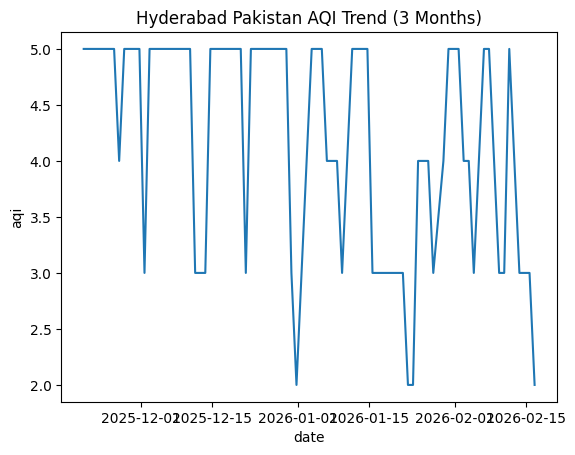

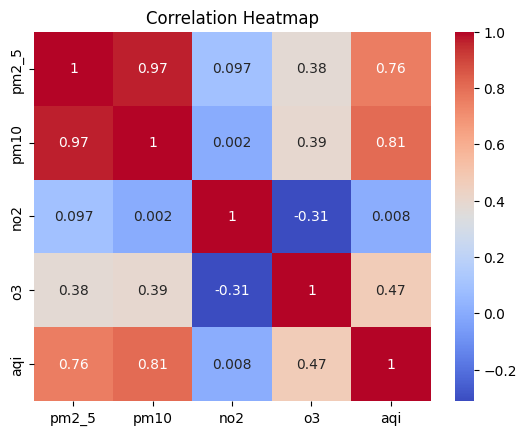

In [6]:
sns.lineplot(x="date", y="aqi", data=df)
plt.title("Hyderabad Pakistan AQI Trend (3 Months)")
plt.show()

sns.heatmap(
    df[["pm2_5","pm10","no2","o3","aqi"]].corr(),
    annot=True,
    cmap="coolwarm"
)
plt.title("Correlation Heatmap")
plt.show()


# Prepare ML Data

In [7]:
features = [
    "pm2_5","pm10","no2","o3",
    "Hour","Day","Month","Weekday",
    "PM_Change","PM_Ratio"
]

X = df[features]
y = df["aqi"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# Train Model

In [8]:
rf_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)

rf_model.fit(X_train, y_train)


RandomForestRegressor(n_estimators=200, random_state=42)

# Evaluate Final Model 

In [9]:
pred = rf_model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, pred)))
print("R2 Score:", r2_score(y_test, pred))


MAE: 0.14194444444444443
RMSE: 0.29436607971858586
R2 Score: 0.9054712121212122


# Predict Next 3 Days

In [10]:
latest = X.iloc[-1]

future = []
for i in range(1, 4):
    row = latest.copy()
    row["Day"] += i
    future.append(row)

future_df = pd.DataFrame(future)

future_predictions = rf_model.predict(future_df)
future_predictions


array([5., 5., 5.])

In [11]:
last_date = df["date"].max()


In [12]:
future_dates = pd.date_range(
    start=last_date + pd.Timedelta(days=1),
    periods=3,
    freq="D"
)


In [13]:
pred_df = pd.DataFrame({
    "Date": future_dates,
    "Predicted_AQI": future_predictions
})

pred_df


,Date,Predicted_AQI
0,2026-02-17 18:00:00,5.0
1,2026-02-18 18:00:00,5.0
2,2026-02-19 18:00:00,5.0


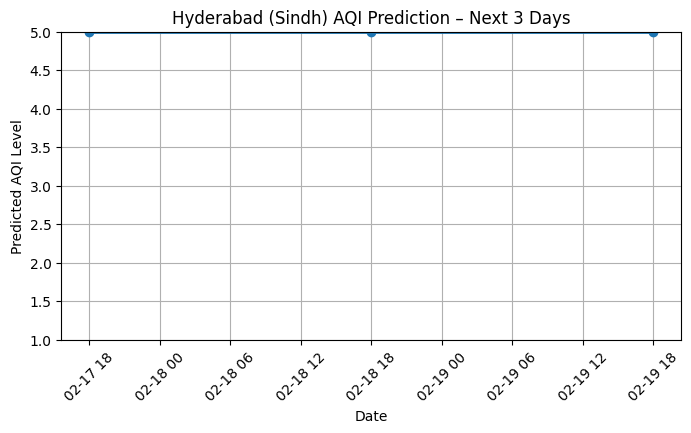

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(
    pred_df["Date"],
    pred_df["Predicted_AQI"],
    marker="o",
    linewidth=2
)

plt.title("Hyderabad (Sindh) AQI Prediction – Next 3 Days")
plt.xlabel("Date")
plt.ylabel("Predicted AQI Level")
plt.xticks(rotation=45)
plt.ylim(1, 5)   # AQI scale
plt.grid(True)
plt.show()


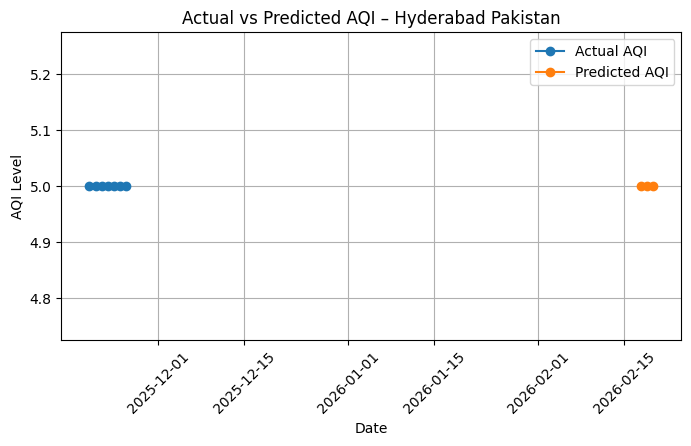

In [15]:
plt.figure(figsize=(8,4))

plt.plot(
    df["date"].tail(7),
    df["aqi"].tail(7),
    label="Actual AQI",
    marker="o"
)

plt.plot(
    pred_df["Date"],
    pred_df["Predicted_AQI"],
    label="Predicted AQI",
    marker="o"
)

plt.title("Actual vs Predicted AQI – Hyderabad Pakistan")
plt.xlabel("Date")
plt.ylabel("AQI Level")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
